# Customer Segmentation - 고객 군집

In [1]:
import warnings
warnings.filterwarnings('ignore')

# I. wget From Github
  - 'Online_Retail.zip' 파일 다운로드

In [2]:
!wget https://raw.githubusercontent.com/rusita-ai/pyData/master/Online_Retail.zip

--2023-03-24 00:56:52--  https://raw.githubusercontent.com/rusita-ai/pyData/master/Online_Retail.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22824989 (22M) [application/zip]
Saving to: ‘Online_Retail.zip’

Online_Retail.zip   100%[===================>]  21.77M  --.-KB/s    in 0.07s   

2023-03-24 00:56:52 (309 MB/s) - ‘Online_Retail.zip’ saved [22824989/22824989]



- 다운로드 결과 확인

In [4]:
!ls -l

total 22296
-rw-r--r-- 1 root root 22824989 Mar 24 00:56 Online_Retail.zip
drwxr-xr-x 1 root root     4096 Mar 22 13:39 sample_data


# II. Data Preprocessing

> ## 1) Unzip 'Online_Retail.zip'

   - Colab 파일시스템에 'Online_Retail.csv' 파일 생성

In [5]:
!unzip Online_Retail.zip

Archive:  Online_Retail.zip
  inflating: Online_Retail.xlsx      


- Online_Retail.zip 파일 확인

In [6]:
!ls -l

total 45456
-rw-r--r-- 1 root root 23715344 Mar  7  2021 Online_Retail.xlsx
-rw-r--r-- 1 root root 22824989 Mar 24 00:56 Online_Retail.zip
drwxr-xr-x 1 root root     4096 Mar 22 13:39 sample_data


> ## 2) 데이터 읽어오기

  - pandas DataFrame

In [7]:
%%time

import pandas as pd
DF = pd.read_excel('Online_Retail.xlsx')

DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
CPU times: user 1min 15s, sys: 745 ms, total: 1min 16s
Wall time: 1min 20s


> ## 3) 데이터 설명

  - InvoiceNo : 주문 번호, 'C' 시작은 주문취소
  - StockCode : 제품 코드(Item Code)
  - Description : 제품 설명
  - Quantity : 주문 건수
  - InvoiceDate : 주문 날짜
  - UnitPrice : 제품 단가
  - CustomerID : 고객번호
  - Country : 국가명(주문 고객 국적)

In [8]:
DF.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


> ## 4) 결측치 제거

  - 'Quantity', 'UnitPrice', 'CustomerID'

In [9]:
DF = DF[DF['Quantity'] > 0]
DF = DF[DF['UnitPrice'] > 0]
DF = DF[DF['CustomerID'].notnull()]

DF.shape

(397884, 8)

- 결과 확인

In [10]:
DF.isnull().sum(axis=0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

> ## 5) 'United Kingdom' 만 사용
  
  - 대부분의 구매자가 영국국적

In [12]:
DF['Country'].value_counts()[:10]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: Country, dtype: int64

 - 영국 데이터만 추출

In [13]:
DF = DF[DF['Country'] == 'United Kingdom']

DF.shape


(354321, 8)

# III. RFM 기반 Data Reengineering

  - RECENCY : 가장 최근 상품 구매일에서 오늘까지 기간
  - FREQUENCY : 상품 구매 횟수
  - MONETARY VALUE : 총 구매 금액

> ## 1) 'sale_amount' 추가

  - '주문 금액' = '주문 개수' * '제품 가격'

In [14]:
DF['sale_amount'] = DF['Quantity'] * DF['UnitPrice']

In [15]:
DF.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


  - 'Customer ID' 정수 변환

In [16]:
DF['CustomerID'] = DF['CustomerID'].astype(int)

> ## 2) 주문 특성 확인

  - Top - 5 주문 건수 'Customer ID'

In [18]:
DF['CustomerID'].value_counts().head()

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64

In [20]:
DF.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending = False)[:5]

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64

  - 몇몇 특정 고객이 많은 '주문 건수'와 '주문 금액'을 가지고 있음

 > ## 3) 'Customer ID' 기준으로 DataFrame 재구성

  - Recency : 'InvoiceDate'의 max()
  - Frequency : 'InvoiceNo'의 count()
  - Monetary value : 'sale_amount'의 sum()

In [22]:
aggregations = {'InvoiceDate' : 'max',
                'InvoiceNo'   : 'count',
                'sale_amount' : 'sum'}

DF_CID = DF.groupby('CustomerID').agg(aggregations)

- groupby( ) 결과 Index와 Column 이름 수정
  - 'Recency', 'Frequency', 'Monetary'

In [23]:
DF_CID = DF_CID.rename(columns= {'InvoiceDate' : 'Recency',
                                 'InvoiceNo'   : 'Frequency',
                                 'sale_amount' : 'Monetary'})

DF_CID = DF_CID.reset_index()

- RMF 변경 결과

In [24]:
DF_CID.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73
3,12749,2011-12-06 09:56:00,199,4090.88
4,12820,2011-12-06 15:12:00,59,942.34


> ## 4) 최근 구매일자 Day로 변경
  - 오늘 날짜에서 최근 구매날짜('Recency')를 뺀 일자

In [25]:
import datetime as dt

DF_CID['Recency'] = dt.datetime(2011, 12, 10) - DF_CID['Recency']
DF_CID['Recency'] = DF_CID['Recency'].apply(lambda x : x.days + 1)

- 처리 결과 확인

In [26]:
DF_CID.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73
3,12749,4,199,4090.88
4,12820,4,59,942.34


> ## 5) Visualization

- 변수 별 분포 확인

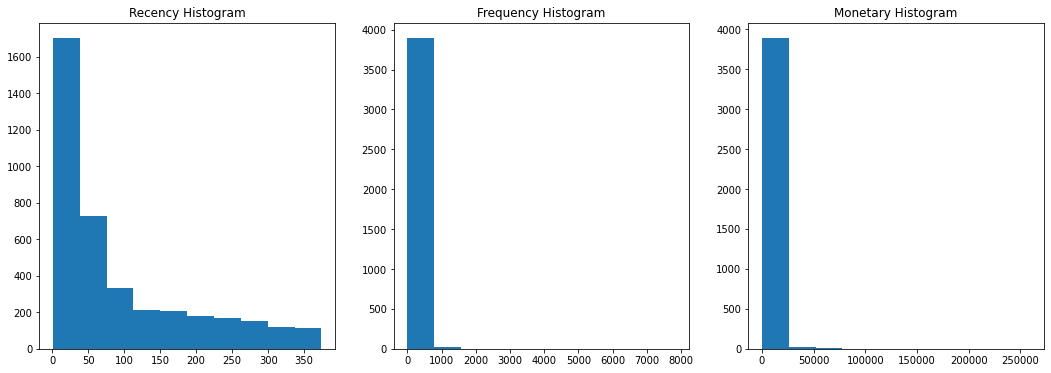

In [28]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 6))

ax1.set_title('Recency Histogram')
ax1.hist(DF_CID['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(DF_CID['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(DF_CID['Monetary'])

plt.show()


# IV. K-means Clustering

> ## 1) Log Transformation

In [29]:
import numpy as np

DF_CID['Recency_Log'] = np.log1p(DF_CID['Recency'])
DF_CID['Frequency_Log'] = np.log1p(DF_CID['Frequency'])
DF_CID['Monetary_Log'] = np.log1p(DF_CID['Monetary'])


> ## 2) 변경된 분포 확인

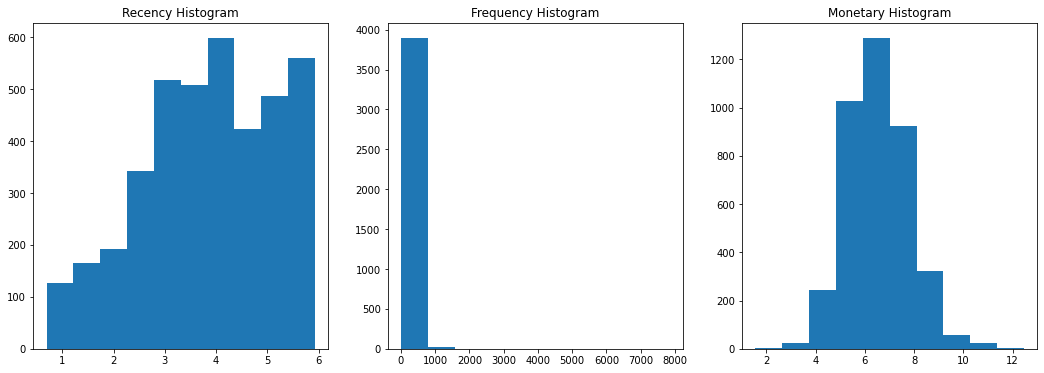

In [30]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 6))

ax1.set_title('Recency Histogram')
ax1.hist(DF_CID['Recency_Log'])

ax2.set_title('Frequency Histogram')
ax2.hist(DF_CID['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(DF_CID['Monetary_Log'])

plt.show()

> ## 3) 학습 데이터 추출

In [31]:
X_input_scaled = DF_CID[['Recency_Log', 'Frequency_Log', 'Monetary_Log']].values

> ## 2) Modeling

  - K-means

In [32]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5,
                random_state = 2045)

kmeans.fit_predict(X_input_scaled)

array([1, 4, 4, ..., 0, 4, 2], dtype=int32)

> ## 3) Silhouette Score

In [33]:
from sklearn.metrics import silhouette_score
silhouette_score(X_input_scaled, kmeans.fit_predict(X_input_scaled))

0.2770451088257186